### Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use("ggplot")
plt.rc('font', family='NanumGothic')

### Data Load

In [3]:
customer = pd.read_csv('./data_in/customers.csv')
location = pd.read_csv('./data_in/locations.csv')
order_items = pd.read_csv('./data_in/order_items.csv')
orders = pd.read_csv('./data_in/orders.csv')
payments = pd.read_csv('./data_in/payments.csv')
product = pd.read_csv('./data_in/products.csv')
review = pd.read_csv('./data_in/reviews.csv')
seller = pd.read_csv('./data_in/sellers.csv')

### Data

In [4]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87955 entries, 0 to 87954
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Customer_id              87955 non-null  object
 1   Customer_unique_id       87955 non-null  object
 2   Customer_zipcode_prefix  87955 non-null  int64 
 3   Customer_city            87955 non-null  object
 4   Customer_state           87955 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87955 entries, 0 to 87954
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Order_id                       87955 non-null  object
 1   Customer_id                    87955 non-null  object
 2   Order_status                   87955 non-null  object
 3   Order_purchase_timestamp       87955 non-null  object
 4   Order_delivered_carrier_date   87955 non-null  object
 5   Order_delivered_customer_date  87955 non-null  object
 6   Order_estimated_delivery_date  87955 non-null  object
dtypes: object(7)
memory usage: 4.7+ MB


In [6]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100557 entries, 0 to 100556
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Order_id       100557 non-null  object 
 1   Order_item_id  100557 non-null  int64  
 2   Product_id     100557 non-null  object 
 3   Seller_id      100557 non-null  object 
 4   Price          100557 non-null  float64
 5   Freight_value  100557 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


### EDA

#### Top10 제품 카테고리 시각화

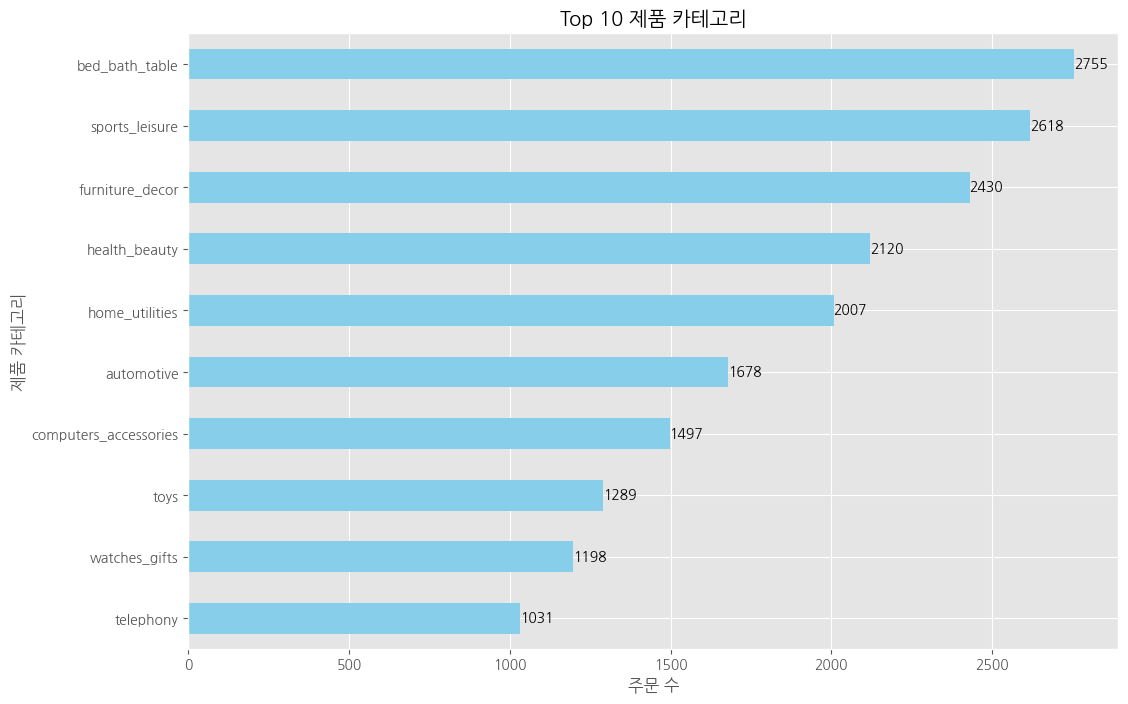

In [7]:
# 카테고리별 주문 수 계산
category_cnt = product['Product_category_name'].value_counts().head(10)

plt.figure(figsize=(12, 8))
bars = category_cnt.sort_values(ascending=True).plot(kind='barh', color='skyblue')

plt.title('Top 10 제품 카테고리')
plt.xlabel('주문 수')
plt.ylabel('제품 카테고리')

# 각 바 위에 값 표시
for bar in bars.containers[0]:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{int(bar.get_width())}', va='center')

plt.show()

#### 고객 Top 10 도시 시각화

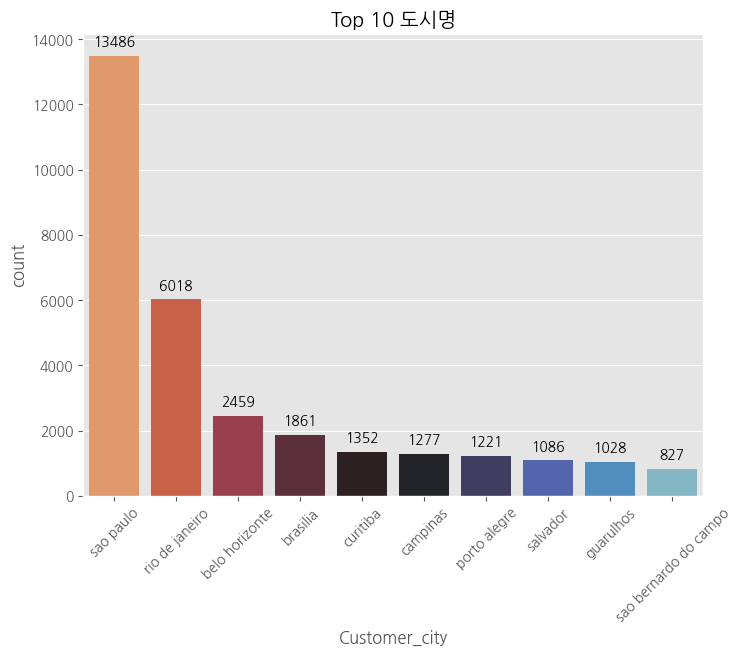

In [8]:
# 상위 10개 도시 선택
top10_cities = customer['Customer_city'].value_counts().head(10).index

# 상위 10개 도시에 대한 데이터만 필터링
data = customer[customer['Customer_city'].isin(top10_cities)]

# 시각화
plt.figure(figsize=(8,6))
ax = sns.countplot(x='Customer_city', data=data,
                   order=data['Customer_city'].value_counts().index, 
                   palette='icefire_r')

plt.title('Top 10 도시명')
plt.xticks(rotation=45) # 도시 이름이 긴 경우를 위해 x축 라벨 회전

# 각 바 위에 값 표시
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()


#### 지불형태 시각화

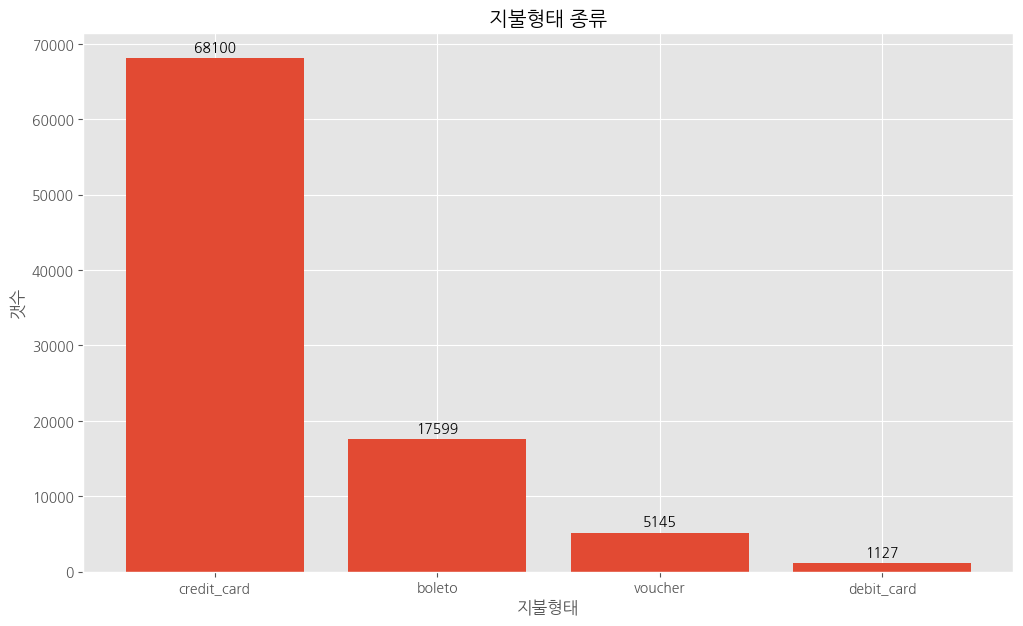

In [9]:
# 지불 형태별 개수 계산
category_counts = payments['Payment_type'].value_counts()

# 바 그래프 그리기
fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(category_counts.index, category_counts)

# 각 바에 카운트 값 표시
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_xlabel('지불형태')
ax.set_ylabel('갯수')
ax.set_title('지불형태 종류')

plt.show()

### KPI Definition

#### 월별 매출 시각화

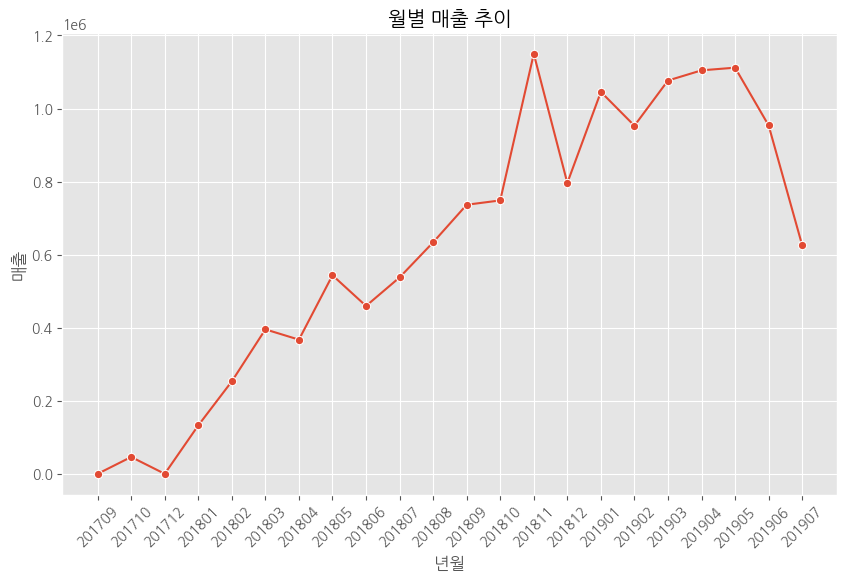

In [10]:
order = orders.copy()

order['Order_purchase_timestamp'] = pd.to_datetime(order['Order_purchase_timestamp'])
order['YearMonth'] = order['Order_purchase_timestamp'].dt.strftime('%Y%m')

merged_orders = pd.merge(order, order_items, on='Order_id', how='left')
merged_orders['Revenue'] = merged_orders['Price'] * merged_orders['Order_item_id']
monthly_revenue = merged_orders.groupby('YearMonth')['Revenue'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='YearMonth', y='Revenue', data=monthly_revenue, marker='o')
plt.title('월별 매출 추이')
plt.xlabel('년월')
plt.ylabel('매출')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [11]:
orders_customers = pd.merge(order, customer, on='Customer_id', how='inner')
orders_monthly_active = orders_customers.groupby('YearMonth')['Customer_unique_id'].nunique().reset_index()

orders_monthly_active.head()

,YearMonth,Customer_unique_id
0,201709,1
1,201710,263
2,201712,1
3,201801,716
4,201802,1616


#### MAU

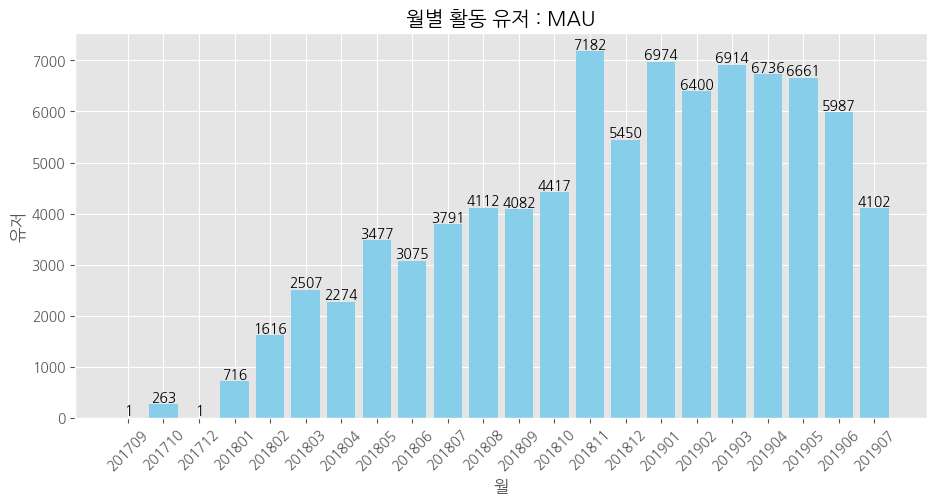

In [12]:
# 바 차트 그리기
plt.figure(figsize=(11, 5))
bars = plt.bar(orders_monthly_active['YearMonth'], orders_monthly_active['Customer_unique_id'], color='skyblue')

# 타이틀 및 라벨 설정
plt.title('월별 활동 유저 : MAU')
plt.xlabel('월')
plt.ylabel('유저')
plt.xticks(rotation=45)

# 각 바 위에 값 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

plt.show()

C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


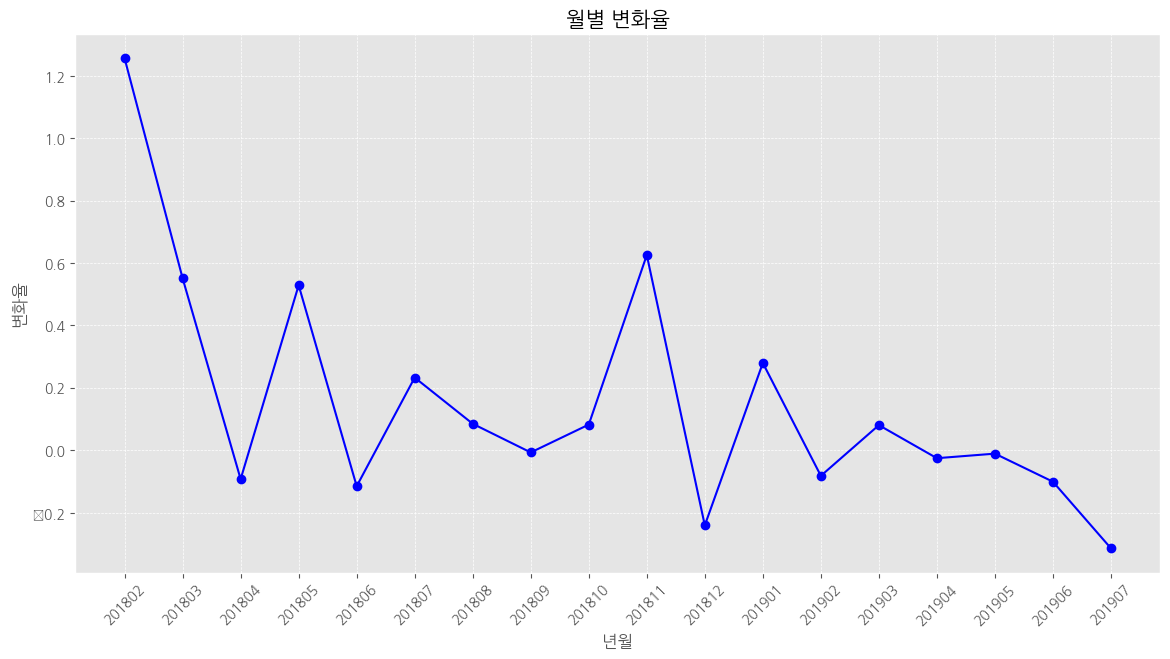

In [196]:
orders_monthly_active['Monthlychange'] = orders_monthly_active['Customer_unique_id'].pct_change()


filtered_data = orders_monthly_active.query("YearMonth > '201801'")


plt.figure(figsize=(14, 7))
plt.plot(filtered_data['YearMonth'], filtered_data['Monthlychange'], marker='o', linestyle='-', color='blue')
plt.title('월별 변화율', fontsize=15)
plt.xlabel('년월', fontsize=12)
plt.ylabel('변화율', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [14]:
seller

,Seller_id,Seller_zipcode_prefix,Seller_city,Seller_state
0,SELLER_0000,13023,campinas,SP
1,SELLER_0001,13844,mogi guacu,SP
2,SELLER_0002,12914,braganca paulista,SP
3,SELLER_0003,20920,rio de janeiro,RJ
4,SELLER_0004,55325,brejao,PE
...,...,...,...,...
2758,SELLER_2758,87111,sarandi,PR
2759,SELLER_2759,88137,palhoca,SC
2760,SELLER_2760,4650,sao paulo,SP
2761,SELLER_2761,96080,pelotas,RS


In [16]:
order_items

,Order_id,Order_item_id,Product_id,Seller_id,Price,Freight_value
0,ORDER_75477,1,PRODUCT_23128,SELLER_0452,58.90,13.29
1,ORDER_63604,1,PRODUCT_24351,SELLER_0414,239.90,19.93
2,ORDER_05566,1,PRODUCT_20226,SELLER_1637,199.00,17.87
3,ORDER_04632,1,PRODUCT_07878,SELLER_1445,199.90,18.14
4,ORDER_61452,1,PRODUCT_03505,SELLER_0581,21.90,12.69
...,...,...,...,...,...,...
100552,ORDER_70405,1,PRODUCT_04209,SELLER_2078,299.99,43.41
100553,ORDER_62069,1,PRODUCT_08229,SELLER_1593,350.00,36.53
100554,ORDER_46632,1,PRODUCT_21462,SELLER_0528,99.90,16.95
100555,ORDER_52966,1,PRODUCT_19978,SELLER_2563,55.99,8.72


In [71]:
payments

,Order_id,Payment_sequential,Payment_type,Payment_installments,Payment_value
0,ORDER_66617,1,credit_card,8,99.33
1,ORDER_86954,1,credit_card,1,24.39
2,ORDER_38852,1,credit_card,1,65.71
3,ORDER_57443,1,credit_card,8,107.78
4,ORDER_11244,1,credit_card,2,128.45
...,...,...,...,...,...
91966,ORDER_46197,1,credit_card,1,194.11
91967,ORDER_37509,1,credit_card,2,198.94
91968,ORDER_85760,1,boleto,1,363.31
91969,ORDER_35237,1,credit_card,2,96.80


In [87]:
prep_s_o = pd.merge(seller, order_items, on= 'Seller_id', how= 'right')

prep_selling = pd.merge(prep_s_o, payments,  on= 'Order_id', how= 'left')

prep_selling = pd.merge(prep_selling, product, on= 'Product_id', how= 'left')

In [88]:
prep_selling

,Seller_id,Seller_zipcode_prefix,Seller_city,Seller_state,Order_id,Order_item_id,Product_id,Price,Freight_value,Payment_sequential,Payment_type,Payment_installments,Payment_value,Product_category_name,Product_weight_g,Product_length_cm,Product_height_cm,Product_width_cm
0,SELLER_0452,27277,volta redonda,SP,ORDER_75477,1,PRODUCT_23128,58.90,13.29,1,credit_card,2,72.19,cool_stuff,650.0,28.0,9.0,14.0
1,SELLER_0414,3471,sao paulo,SP,ORDER_63604,1,PRODUCT_24351,239.90,19.93,1,credit_card,3,259.83,pet_shop,30000.0,50.0,30.0,40.0
2,SELLER_1637,37564,borda da mata,MG,ORDER_05566,1,PRODUCT_20226,199.00,17.87,1,credit_card,5,216.87,furniture_decor,3050.0,33.0,13.0,33.0
3,SELLER_1445,87900,loanda,PR,ORDER_04632,1,PRODUCT_07878,199.90,18.14,1,credit_card,3,218.04,garden_tools,3750.0,35.0,40.0,30.0
4,SELLER_0581,14091,ribeirao preto,SP,ORDER_61452,1,PRODUCT_03505,21.90,12.69,1,boleto,1,34.59,home_utilities,450.0,24.0,8.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105081,SELLER_2078,88303,itajai,SC,ORDER_70405,1,PRODUCT_04209,299.99,43.41,1,boleto,1,343.40,home_utilities,10150.0,89.0,15.0,40.0
105082,SELLER_1593,1206,sao paulo,SP,ORDER_62069,1,PRODUCT_08229,350.00,36.53,1,boleto,1,386.53,computers_accessories,8950.0,45.0,26.0,38.0
105083,SELLER_0528,80610,curitiba,PR,ORDER_46632,1,PRODUCT_21462,99.90,16.95,1,credit_card,3,116.85,sports_leisure,967.0,21.0,24.0,19.0
105084,SELLER_2563,4733,sao paulo,SP,ORDER_52966,1,PRODUCT_19978,55.99,8.72,1,credit_card,3,64.71,computers_accessories,100.0,20.0,20.0,20.0


In [89]:
# 거래 가치가 높은 셀러별 순위와 거래가치들

prep_selling.pivot_table(
    index= 'Seller_id',
    values= 'Payment_value',
    aggfunc= 'sum'
).sort_values(by= 'Payment_value', ascending= False)

,Payment_value
Seller_id,
SELLER_1059,482215.86
SELLER_2194,285755.27
SELLER_0417,281059.41
SELLER_1678,259860.84
SELLER_2423,254767.62
...,...
SELLER_0238,20.19
SELLER_2163,19.21
SELLER_2154,18.56


In [100]:
product['Product_category_name'].describe()

count              29471
unique                72
top       bed_bath_table
freq                2755
Name: Product_category_name, dtype: object

In [97]:
a = prep_selling['Seller_id'] == 'SELLER_1059'

prep_selling[a].sort_values(by= 'Payment_value', ascending= False)

,Seller_id,Seller_zipcode_prefix,Seller_city,Seller_state,Order_id,Order_item_id,Product_id,Price,Freight_value,Payment_sequential,Payment_type,Payment_installments,Payment_value,Product_category_name,Product_weight_g,Product_length_cm,Product_height_cm,Product_width_cm
63375,SELLER_1059,8577,itaquaquecetuba,SP,ORDER_87705,5,PRODUCT_20999,179.99,0.08,1,credit_card,10,2234.66,office_furniture,19400.0,48.0,45.0,56.0
63380,SELLER_1059,8577,itaquaquecetuba,SP,ORDER_87705,10,PRODUCT_20999,179.99,0.08,1,credit_card,10,2234.66,office_furniture,19400.0,48.0,45.0,56.0
63371,SELLER_1059,8577,itaquaquecetuba,SP,ORDER_87705,1,PRODUCT_23954,199.99,88.57,1,credit_card,10,2234.66,office_furniture,17000.0,63.0,58.0,24.0
63372,SELLER_1059,8577,itaquaquecetuba,SP,ORDER_87705,2,PRODUCT_20999,179.99,0.08,1,credit_card,10,2234.66,office_furniture,19400.0,48.0,45.0,56.0
63373,SELLER_1059,8577,itaquaquecetuba,SP,ORDER_87705,3,PRODUCT_20999,179.99,0.08,1,credit_card,10,2234.66,office_furniture,19400.0,48.0,45.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76353,SELLER_1059,8577,itaquaquecetuba,SP,ORDER_42159,1,PRODUCT_10224,79.98,22.87,1,credit_card,1,3.54,office_furniture,7463.0,56.0,64.0,35.0
72949,SELLER_1059,8577,itaquaquecetuba,SP,ORDER_53651,1,PRODUCT_05944,192.99,64.67,2,voucher,1,3.39,office_furniture,14775.0,63.0,60.0,25.0
72952,SELLER_1059,8577,itaquaquecetuba,SP,ORDER_53651,2,PRODUCT_19320,192.99,64.67,2,voucher,1,3.39,office_furniture,16150.0,63.0,62.0,24.0
104596,SELLER_1059,8577,itaquaquecetuba,SP,ORDER_23961,2,PRODUCT_19759,79.99,22.88,1,credit_card,1,1.67,office_furniture,5200.0,45.0,54.0,15.0


In [ ]:

prep_selling.sort_values(by= 'Payment_value', ascending= False)

In [18]:
prep_s_o

,Seller_id,Seller_zipcode_prefix,Seller_city,Seller_state,Order_id,Order_item_id,Product_id,Price,Freight_value
0,SELLER_0452,27277,volta redonda,SP,ORDER_75477,1,PRODUCT_23128,58.90,13.29
1,SELLER_0414,3471,sao paulo,SP,ORDER_63604,1,PRODUCT_24351,239.90,19.93
2,SELLER_1637,37564,borda da mata,MG,ORDER_05566,1,PRODUCT_20226,199.00,17.87
3,SELLER_1445,87900,loanda,PR,ORDER_04632,1,PRODUCT_07878,199.90,18.14
4,SELLER_0581,14091,ribeirao preto,SP,ORDER_61452,1,PRODUCT_03505,21.90,12.69
...,...,...,...,...,...,...,...,...,...
100552,SELLER_2078,88303,itajai,SC,ORDER_70405,1,PRODUCT_04209,299.99,43.41
100553,SELLER_1593,1206,sao paulo,SP,ORDER_62069,1,PRODUCT_08229,350.00,36.53
100554,SELLER_0528,80610,curitiba,PR,ORDER_46632,1,PRODUCT_21462,99.90,16.95
100555,SELLER_2563,4733,sao paulo,SP,ORDER_52966,1,PRODUCT_19978,55.99,8.72


In [68]:
pivot = prep_s_o.pivot_table(
    index= 'Seller_id',
    values= 'Price',
    aggfunc= 'count'
).sort_values(by= 'Price', ascending= False).head(10)

In [70]:
prep_s_o['Seller_id'].describe()

count          100557
unique           2761
top       SELLER_2194
freq             1873
Name: Seller_id, dtype: object

In [66]:
filter_1 = prep_s_o['Seller_id'] == 'SELLER_2330'

prep_s_o[filter_1].pivot_table(
    index= 'Product_id',
    aggfunc= 'count'
).sort_values(by= 'Price', ascending= False).head(10)

,Freight_value,Order_id,Order_item_id,Price,Seller_city,Seller_id,Seller_state,Seller_zipcode_prefix
Product_id,,,,,,,,
PRODUCT_12895,136,136,136,136,136,136,136,136
PRODUCT_10235,111,111,111,111,111,111,111,111
PRODUCT_00703,106,106,106,106,106,106,106,106
PRODUCT_24179,86,86,86,86,86,86,86,86
PRODUCT_17367,66,66,66,66,66,66,66,66
PRODUCT_03813,53,53,53,53,53,53,53,53
PRODUCT_22853,51,51,51,51,51,51,51,51
PRODUCT_06505,49,49,49,49,49,49,49,49
PRODUCT_25463,41,41,41,41,41,41,41,41


In [59]:
filte_2 = product['Product_id'] == 'PRODUCT_12895'

In [60]:
product[filte_2]

,Product_id,Product_category_name,Product_weight_g,Product_length_cm,Product_height_cm,Product_width_cm
12895,PRODUCT_12895,watches_gifts,342.0,18.0,13.0,15.0


In [101]:
monthly_revenue

,YearMonth,Revenue
0,201709,0.00
1,201710,46128.70
2,201712,10.90
3,201801,132543.70
4,201802,253174.51
5,201803,395459.60
6,201804,367298.52
7,201805,543552.47
8,201806,459571.81
9,201807,537673.75


In [106]:
product

,Product_id,Product_category_name,Product_weight_g,Product_length_cm,Product_height_cm,Product_width_cm
0,PRODUCT_00000,perfumery,225.0,16.0,10.0,14.0
1,PRODUCT_00001,arts,1000.0,30.0,18.0,20.0
2,PRODUCT_00002,sports_leisure,154.0,18.0,9.0,15.0
3,PRODUCT_00003,home_utilities,625.0,20.0,17.0,13.0
4,PRODUCT_00004,musical_instruments,200.0,38.0,5.0,11.0
...,...,...,...,...,...,...
29466,PRODUCT_29466,furniture_decor,12300.0,40.0,40.0,40.0
29467,PRODUCT_29467,construction_tools_lighting,1700.0,16.0,19.0,16.0
29468,PRODUCT_29468,bed_bath_table,1400.0,27.0,7.0,27.0
29469,PRODUCT_29469,computers_accessories,700.0,31.0,13.0,20.0


In [107]:
merged_orders = pd.merge(merged_orders, product, how= 'left', on= 'Product_id')

In [109]:
merged_orders

,Order_id,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,YearMonth,Order_item_id,Product_id,Seller_id,Price,Freight_value,Revenue,Product_category_name,Product_weight_g,Product_length_cm,Product_height_cm,Product_width_cm
0,ORDER_00000,CUSTOMER_62232,delivered,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18,201810,1.0,PRODUCT_02093,SELLER_0491,29.99,8.72,29.99,home_utilities,500.0,19.0,8.0,13.0
1,ORDER_00001,CUSTOMER_54059,delivered,2018-11-18 19:28:06,2018-11-22 13:39:59,2018-12-02 00:28:42,2018-12-15,201811,1.0,PRODUCT_26747,SELLER_2662,45.00,27.20,45.00,pet_shop,450.0,30.0,10.0,20.0
2,ORDER_00002,CUSTOMER_59535,delivered,2019-02-13 21:18:39,2019-02-14 19:46:34,2019-02-16 18:17:02,2019-02-26,201902,1.0,PRODUCT_10598,SELLER_1354,19.90,8.72,19.90,stationery,250.0,51.0,15.0,15.0
3,ORDER_00003,CUSTOMER_60516,delivered,2018-07-09 21:57:05,2018-07-11 14:58:04,2018-07-26 10:57:55,2018-08-01,201807,1.0,PRODUCT_16703,SELLER_1518,147.90,27.36,147.90,automotive,7150.0,65.0,10.0,65.0
4,ORDER_00004,CUSTOMER_76957,delivered,2018-05-16 13:10:30,2018-05-22 10:07:46,2018-05-26 12:55:51,2018-06-07,201805,1.0,PRODUCT_08274,SELLER_1599,59.99,15.17,59.99,automotive,50.0,16.0,16.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100553,ORDER_88084,CUSTOMER_69438,delivered,2019-02-06 12:58:58,2019-02-07 23:22:42,2019-02-28 17:37:56,2019-03-02,201902,1.0,PRODUCT_01588,SELLER_0031,174.90,20.10,174.90,baby,4950.0,40.0,10.0,40.0
100554,ORDER_88085,CUSTOMER_17637,delivered,2018-08-27 14:46:43,2018-08-28 20:52:26,2018-09-21 11:24:17,2018-09-27,201808,1.0,PRODUCT_13335,SELLER_1892,205.99,65.02,205.99,home_appliances_2,13300.0,32.0,90.0,22.0
100555,ORDER_88086,CUSTOMER_15001,delivered,2019-01-08 21:28:27,2019-01-12 15:35:03,2019-01-25 23:32:54,2019-02-15,201901,1.0,PRODUCT_07372,SELLER_2445,179.99,40.59,179.99,computers_accessories,6550.0,20.0,20.0,20.0
100556,ORDER_88086,CUSTOMER_15001,delivered,2019-01-08 21:28:27,2019-01-12 15:35:03,2019-01-25 23:32:54,2019-02-15,201901,2.0,PRODUCT_07372,SELLER_2445,179.99,40.59,359.98,computers_accessories,6550.0,20.0,20.0,20.0


In [149]:
total = merged_orders.pivot_table(
    columns= 'YearMonth',
    index= 'Product_category_name',
    values= 'Revenue',
    aggfunc= 'count'
).sort_index(ascending= False)

In [159]:
total.fillna(0, inplace= True)

In [182]:
total['201907'] - total['201906']

Product_category_name
watches_gifts                -115.0
toys                          -80.0
the_kitchen                     0.0
telephony                     -87.0
technical_books                -7.0
                              ...  
arts_and_crafts                 7.0
arts                          -12.0
air_conditioning               -5.0
agro_industry_and_commerce      9.0
Unknown                        15.0
Length: 72, dtype: float64

In [194]:
(total['201906'] - total['201905']).sort_values(ascending= True).head()

Product_category_name
furniture_decor   -193.0
watches_gifts     -153.0
garden_tools      -106.0
cool_stuff         -77.0
sports_leisure     -72.0
dtype: float64

In [190]:
(total['201907'] - total['201906']).sort_values(ascending= True)

Product_category_name
health_beauty                   -335.0
bed_bath_table                  -328.0
home_utilities                  -194.0
computers_accessories           -122.0
watches_gifts                   -115.0
                                 ...  
portable_home_oven_and_coffee      6.0
arts_and_crafts                    7.0
agro_industry_and_commerce         9.0
Unknown                           15.0
food                              19.0
Length: 72, dtype: float64

In [195]:
(total['201907'] - total['201905']).sort_values(ascending= True)

Product_category_name
bed_bath_table                                 -303.0
furniture_decor                                -300.0
watches_gifts                                  -268.0
home_utilities                                 -241.0
health_beauty                                  -219.0
                                                ...  
kitchen_laundry_room_dining_garden_furniture      4.0
arts_and_crafts                                   6.0
agro_industry_and_commerce                       11.0
signaling_and_security                           17.0
living_room_furniture                            19.0
Length: 72, dtype: float64

In [163]:
total['YearMonth'].map(
    lambda x: x.

AttributeError: 'float' object has no attribute 'sort_index'

In [152]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='YearMonth', y='', data=total, marker='o')
plt.title('월별 상품품목별 판매량 추이')
plt.xlabel('년월')
plt.ylabel('판매량')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

ValueError: Could not interpret value `YearMonth` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>